## Students
Please fill in your names and S/U-numbers:
* Linda Schmeitz, S1042449
* Enrico Schmitz, s1047521
* Charlotte Cambier van Nooten, s1044122

# Statistical Machine Learning 2020
# Assignment 4
# Deadline: 23 December 2020
## Instructions
* You can __work in groups__ (= max 3 people). __Write the full name and S/U-number of all team members in the header above.__
* Make sure you __fill in any place that says__ `YOUR CODE HERE` or "YOUR ANSWER HERE" __including comments, derivations, explanations, graphs, etc.__ This means that the elements and/or intermediate steps required to derive the answer have to be in the report. (Answers like 'No' or 'x=27.2' by themselves are not sufficient, even when they are the result of running your code.) If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends (if applicable).
* Please do not add new cells unless necessary, try to write the answers only in the provided cells. Before you turn this problem in, __make sure everything runs as expected__. First, *restart the kernel* (in the menubar, select Kernel$\rightarrow$Restart) and then *run all cells* (in the menubar, select Cell$\rightarrow$Run All). The assignment was written in (and we strongly recommend using) Python 3 by using the corresponding Python 3 kernel for Jupyter.
* The assignment includes certain cells that contain tests. Most of the tests are marked as *hidden* and are used for automatic grading. NB: These hidden tests do not provide any feedback! There are also a couple of tests / checks that are visible, which are meant to help you avoid basic coding errors.
* __Upload the exercises to Brightspace as a single .zip file containing the submitter's S/U-number: 'SML20_as04_&lt;S/U-number&gt;.zip'__, for example 'SML20_as04_S123456.zip'. For those working in groups, it is sufficient if one team member uploads the solutions.
* For any problems or questions, send us an email, or just ask. Email addresses: G.Bucur@cs.ru.nl, Yuliya.Shapovalova@ru.nl, and tomc@cs.ru.nl.

## Introduction
Assignment 4 consists of:
1. Gaussian processes (50 points);
2. __EM and doping (50 points)__;
3. Gibbs sampling and Metropolis-Hastings (50 points);
4. Variational inference for Bayesian linear regression (50 points).

## Libraries

First, we import the basic libraries necessary to develop this assignment. Of course you are free to import further libraries, if required, in the allotted cells.

In [2]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import math

# Set fixed random seed for reproducibility
np.random.seed(2020)

## EM and doping (50 points)
In a certain hypothetical sport, banned substance 'X' has become popular as a performance enhancing drug, as its presence is hard to establish in blood samples directly. Recently, it has been discovered that users of the drug tend to show a strong positive correlation between concentrations of two other quantities, $x_1$ and $x_2$, present in the blood. In contrast, 'clean' athletes tend to fall in one of two or three groups, that either show no or a negative correlation between $x_1$ and $x_2$. Unfortunately, as each sample contains only a single, instantaneous, measurement for each variable, it is not possible to establish this correlation from the sample. However, in many cases it is possible to distinguish to which _class_ a certain sample belongs by also looking at the values of two other measured variables, $x_3$ and $x_4$: certain combinations of measured values are often typical for one class but highly unusual for others.

After a high profile event, a large scale test has resulted in 2000 samples. Rumours suggest the number of positives could be as high as 20\%. However, the exact relationship between different classes and typical $\mathbf{x}$ values is still not clear. This is where the EM-algorithm comes in ...

The blood sample measurements are modelled as a mixture of $K$ Gaussians, one for each class
$$$
p(\mathbf{x}|\mathbf{\mu}, \mathbf{\Sigma}, \mathbf{\pi}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)
$$$
where $\mathbf{x} = [x_1, x_2, x_3, x_4]$ represents the values for the measured quantities in the blood sample, $\mathbf{\mu} = \{\mathbf{\mu}_1, \ldots, \mathbf{\mu}_K\}$ and $\mathbf{\Sigma} = \{\Sigma_1, \ldots, \Sigma_K\}$ are the means and covariance matrices of the Gaussians for each class, and $\mathbf{\pi} = \{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients in the overall data set.

We first load the data and set $N$ to the number of datapoints and $D$ to the number of variables in the data set $X$.

In [3]:
# Load data
X = np.loadtxt("a011_mixdata.txt")
N, D = X.shape

1. Try to give an estimate of the number, size and shape of the classes in the data, by plotting the distribution of the variables, e.g using `plt.hist`, `plt.scatter` or `scatter3()`.

In [ ]:
!pip install seaborn
import seaborn as sns

N: 2000  D: 4


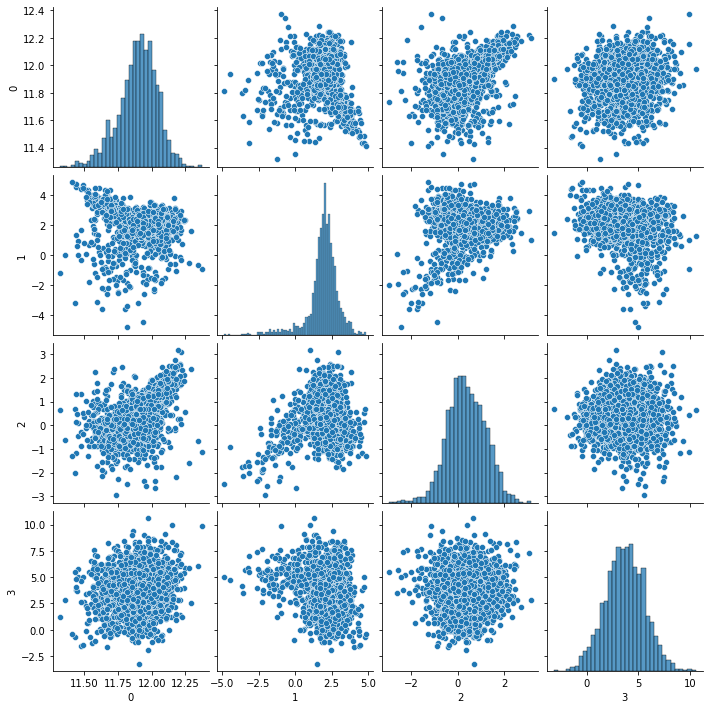

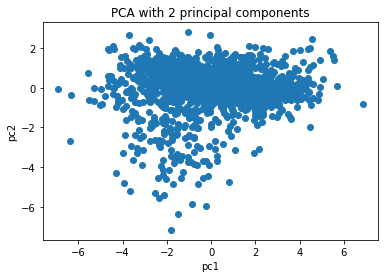

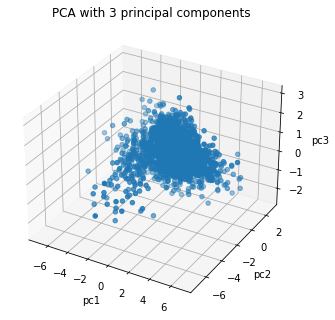

In [4]:
"""
Experiment with different plots.
"""
print("N:",N," D:",D)

df = pd.DataFrame(X)
sns.pairplot(data=df, vars=[0,1,2,3])

plt.show()

Y = X - X.mean(axis=0).reshape(1,-1)
[U, S, V] = np.linalg.svd(Y)

Z = np.dot(Y,V.transpose()) #Note the transpose!

plt.scatter(Z[:,0],Z[:,1])
plt.title('PCA with 2 principal components')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Z[:,0],Z[:,1],Z[:,2])
plt.title('PCA with 3 principal components')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

Looking at the PCA plot with 2 principal components it looks like there are 2 classes. One bigger class (on top of the graph) and one sparse class (on the bottom of the graph).
When adding the thirth principal component to the graph it looks like the big cluster can be separated into two seperate similar sized clusters.

2. Implement an EM-algorithm using the description and formulas given in Bishop, $S9.2.2$. Use variable $K$ for the number of classes and choose a priori equal mixing coefficients $\pi_k$. Initialize the means $\mathbf{\mu}_k$ to random values around the sample mean of each variable, e.g. set $\mu_{k,1}$ to $\bar{x}_1 + [-1 \leq \epsilon \leq +1]$. Initialize the $\mathbf{\Sigma}_k$ to diagonal matrices with reasonably high variances, e.g. `random.randint(2,6)`, to avoid very small responsibilities in the first step. Make sure the EM-loop runs over at least 100 iterations. Display relevant quantities, at least the log likelihood (9.28), after each step so you can monitor progress and convergence.

In [106]:
"""
Implement the EM algorithm.
"""
def e_step (X,K,pi_k,mu_k,Sigma_k): #equation 9.23
    N = len(X)

    z = np.zeros((K,N)) #K x n

    for k in range(K):
        for n in range(N):
            z[k,n] = pi_k[k] *  mvn.pdf(X[n],mu_k[k], Sigma_k[k])
    z = np.divide(z, np.sum(z, axis=0))

    return(z)

def m_step (X, K, z): #equaions 9.24, 9.25, 9.26, 9.27
    N, D = np.shape(X)

    # 1. pi_k (dimension is K), equation 9.26
    pi_k = np.mean(z,axis=1)
    pi_k = np.sum(z,axis=1)/N

    # 2. mu_k, equation 9.24
    mu_k = np.zeros((K,D))
    for k in range(K):
        for n in range(N):
            mu_k[k] += z[k,n]*X[n]
    mu_k = np.divide(mu_k.T, np.sum(z, axis=1)).T 

    # 3. Sigma_k, equation 9.25
    Sigma_k = np.zeros((K,D,D)) 
    for k in range(K):
        for n in range(N):
            y = X[n]- mu_k[k] #, (D,1)) 
            Sigma_k[k] += z[k,n] * np.outer(y,y) #np.dot(y, y.T)
        Sigma_k[k] /= z[k,:].sum()

    return(pi_k, mu_k, Sigma_k) 

def EM_algorithm (X, K=4, iterations=100, crit = 0.01):
    # 1. initialize
    N, D = np.shape(X)
    pi_k = np.repeat(1/K,K) #mixing coefficients
    mu_k = np.zeros((D,K)) #means
    for d in range(D):
        mu_k[d,:] = np.mean(X.T[d])+np.random.randint(-1,1,(1,K))
    mu_k = mu_k.T #dimensions become (K, D)

    Sigma_k = np.zeros((K,D,D))
    for k in range(K):
        Sigma_k[k] = np.diag(np.random.randint(2,6,D))

    #log_likeli_old = 0.0 #initial value log-likelihood
    log_likeli_iter = []

    for i in range(iterations):
        # 2. E-step
        z = e_step(X,K,pi_k,mu_k,Sigma_k)

        # 3. M_step
        pi_k, mu_k, Sigma_k = m_step(X, K, z)
        
        # 4. Evaluate log-likelihood
        log_likeli_new = 0
        n = len(X[0])

        for n in range(N):
            t = 0
            for k in range(K): 
                t += pi_k[k] * mvn.pdf(X[n],mu_k[k], Sigma_k[k])
            log_likeli_new +=  np.log(t)
            
        #if np.abs(log_likeli_new-log_likeli_old) >= crit:
        #    log_likeli_old = log_likeli_new
        
        if ((i+1) % 10 == 0):
            print("Log likelihood:", log_likeli_new, ",iteration:",i+1)
        log_likeli = log_likeli_new
        log_likeli_iter.append(log_likeli)
      
    return pi_k, mu_k, Sigma_k, log_likeli_iter, z

In [109]:
pi_K4, mu_K4, Sigma_K4, EM_K4, z_K4 = EM_algorithm (X, K=4, iterations=100)

Log likelihood: -6431.334719893254 ,iteration: 10
Log likelihood: -5990.209581647606 ,iteration: 20
Log likelihood: -5989.752437115071 ,iteration: 30
Log likelihood: -5989.75240604929 ,iteration: 40
Log likelihood: -5989.752406033048 ,iteration: 50
Log likelihood: -5989.752406033038 ,iteration: 60
Log likelihood: -5989.752406033044 ,iteration: 70
Log likelihood: -5989.752406033045 ,iteration: 80
Log likelihood: -5989.75240603303 ,iteration: 90
Log likelihood: -5989.752406033035 ,iteration: 100


Now implement a plot routine that plots the ${x_1,x_2}$ coordinates of the data points, and color each data point  according to the most probable component according to the mixture model.

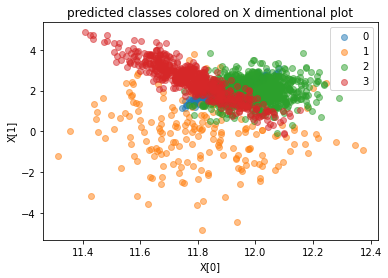

In [111]:
"""
Plot routine.
"""
labels = np.argmax(z_K4,axis=0)
for i in range(len(mu_K4)):
    plt.scatter(X[labels==i,0],X[labels==i,1], label=i, alpha=0.5)
plt.legend()
plt.title('predicted classes colored on X dimentional plot')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.show()


3. Set $K=2$, initialise your random generator and run the EM-algorithm on the data. Try different random initialisations.

    _(Should converge within 50 steps to two clusters, accounting for $\pm$1/3 resp. 2/3 of the data)._

    Plot the ${x_1,x_2}$ coordinates coloured according to the most probable component.
    
    **Note:** Add more cells if necessary.

In [103]:
"""
Run the EM algorithm. 
"""
pi_K2, mu_K2, Sigma_K2, EM_K2, z_K2  = EM_algorithm (X, K=2, iterations=50)

Log likelihood: -7936.0017013449105 ,iteration: 1
Log likelihood: -7642.527199940752 ,iteration: 2
Log likelihood: -7391.981934258457 ,iteration: 3
Log likelihood: -7260.559649475523 ,iteration: 4
Log likelihood: -7200.541374653039 ,iteration: 5
Log likelihood: -7167.066498944589 ,iteration: 6
Log likelihood: -7140.8249383730945 ,iteration: 7
Log likelihood: -7118.955152385663 ,iteration: 8
Log likelihood: -7101.722362368206 ,iteration: 9
Log likelihood: -7088.574187963248 ,iteration: 10
Log likelihood: -7078.7593060084 ,iteration: 11
Log likelihood: -7071.724070271094 ,iteration: 12
Log likelihood: -7066.929863188629 ,iteration: 13
Log likelihood: -7063.808838368973 ,iteration: 14
Log likelihood: -7061.839699720314 ,iteration: 15
Log likelihood: -7060.6122771158225 ,iteration: 16
Log likelihood: -7059.842390689923 ,iteration: 17
Log likelihood: -7059.349550820668 ,iteration: 18
Log likelihood: -7059.024644413213 ,iteration: 19
Log likelihood: -7058.803119983446 ,iteration: 20
Log like

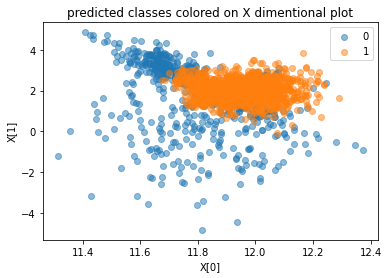

In [108]:
"""
Plot the most probable component. 
"""
labels = np.argmax(z_K2,axis=0)
for i in range(len(mu_K2)):
    plt.scatter(X[labels==i,0],X[labels==i,1], label=i, alpha=0.5)
plt.legend()
plt.title('predicted classes colored on X dimentional plot')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.show()

Describe what happens and compare the results of the different initialisations.

The first thing that is noticible is that the log likelihood values are higher with k2 almost 10x higher. This time you only use half of your data so this could explain the difference.


Compute the correlation coefficients
$$
\rho_{12} = \frac{\mathrm{cov}[x_1,x_2]}{\sqrt{\mathrm{var}[x_1] \mathrm{var}[x_2]}}
$$
of each of the components (i.e., use their covariance matrices to compute variances and covariances in (\ref{correlationcoeff}), see also (Bishop, eq. (2.93)).

**Hint**: According to Wikipedia, the correlation is none if $|\rho|<0.1$, small if $0.1<|\rho|<0.3$, medium if $0.3<|\rho|<0.5$ and strong if $|\rho|>0.5$.

In [112]:
"""
Compute the correlation coefficients. 
"""
p = np.corrcoef(X[:,0],X[:,1])
np.abs(p)

array([[1.        , 0.14555739],
       [0.14555739, 1.        ]])

Does either class show the characteristic strong positive correlation for $\{x_1, x_2\}$?

No, both are showing a medium characteristic correlation for $\{x_1,x_2\}$

4. Increase the number of classes to $K=3$ and rerun your algorithm on the data, again trying different random initializations. Plot the ${x_1,x_2}$ coordinates colored according to the most probable component and compute the correlation coefficients of each of the components. Check both your plot and your coefficients if one of the clusters now displays the strong positive $\{x_1, x_2\}$ correlation we are looking for.

    Increase to $K=4$, do the same, and see if this improves your result (in terms of detection of the doping-cluster). Based on your findings, is the rumoured 1-in-5 estimate for users of X credible?
    
    **Note:** Add more cells if necessary.

In [113]:
"""
Run the EM algorithm with K=3. 
"""
pi_K3, mu_K3, Sigma_K3, EM_K3, z_K3  = EM_algorithm (X, K=3, iterations=60)

Log likelihood: -6556.595780906265 ,iteration: 10
Log likelihood: -6551.139964891616 ,iteration: 20
Log likelihood: -6551.130327808904 ,iteration: 30
Log likelihood: -6551.130293635197 ,iteration: 40
Log likelihood: -6551.130293502425 ,iteration: 50
Log likelihood: -6551.130293501858 ,iteration: 60


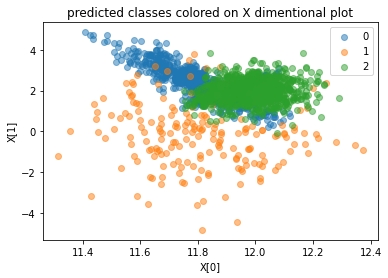

In [114]:
"""
Plot K=3
"""
labels = np.argmax(z_K3,axis=0)
for i in range(len(mu_K3)):
    plt.scatter(X[labels==i,0],X[labels==i,1], label=i, alpha=0.5)
plt.legend()
plt.title('predicted classes colored on X dimentional plot')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.show()

In [115]:
"""
Run the EM algorithm with K=4. 
"""
pi_K4, mu_K4, Sigma_K4, EM_K4, z_K4  = EM_algorithm (X, K=4, iterations=60)

Log likelihood: -6229.074528207831 ,iteration: 10
Log likelihood: -5989.775176845085 ,iteration: 20
Log likelihood: -5989.752409169717 ,iteration: 30
Log likelihood: -5989.752406034861 ,iteration: 40
Log likelihood: -5989.752406033035 ,iteration: 50
Log likelihood: -5989.752406033032 ,iteration: 60


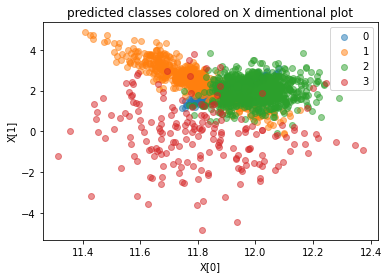

In [116]:
"""
Plot K=4
"""
p = []
labels = np.argmax(z_K4,axis=0)
for i in range(len(mu_K4)):
    plt.scatter(X[labels==i,0],X[labels==i,1], label=i, alpha=0.5)
plt.legend()
plt.title('predicted classes colored on X dimentional plot')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.show()

Based on the finding, we believe the 1-in-5 estimate for users of X is credible

Having found the offending cluster in the data using the EM-algorithm, we are now presented with four samples $\{A, B, C, D\}$, with values for $[x_1, x_2, x_3, x_4]$ given as:
\begin{eqnarray*}
\text{A} & = & [11.85, 2.2, 0.5, 4.0] \\
\text{B} & = & [11.95, 3.1, 0.0, 1.0] \\
\text{C} & = & [12.00, 2.5, 0.0, 2.0] \\
\text{D} & = & [12.00, 3.0, 1.0, 6.3]
\end{eqnarray*}
One of these is from a subject who took drug X, and one is from a subject who tried to tamper with the test by artificially altering one or more of the $x_i$ levels in his/her blood sample.

5. Identify which sample belongs to the suspected user and which one belongs to the 'fraud'.

$A = [11.85, 2.2, 0.5, 4.0] $

$B = [11.95, 3.1, 0.0, 1.0 ] $

$C = [12.00, 2.5, 0.0, 2.0 ] $

$D = [12.00, 3.0, 1.0, 6.3 ] $

A belongs to suspected user and D belongs to the fraud

In [125]:
X = [[11.85,2.2,0.5,4],
[11.95,3.1,0,1],
[12,2.5,0,2],
[12,3,1,6.3]]
for n in range(4):
    for k in range(3):
        print("N:", n," K:", k)
        print('responsibility ',pi_K3[k] *  mvn.pdf(X[n],mu_K3[k], Sigma_K3[k]))
    print()


N: 0  K: 0
responsibility  0.09462034625293403
N: 0  K: 1
responsibility  0.00116622269236206
N: 0  K: 2
responsibility  0.18266759809090893

N: 1  K: 0
responsibility  0.00341192707551363
N: 1  K: 1
responsibility  5.1189862659689025e-08
N: 1  K: 2
responsibility  1.2815143266690247e-10

N: 2  K: 0
responsibility  0.013679675108824453
N: 2  K: 1
responsibility  2.8399331187425495e-06
N: 2  K: 2
responsibility  2.124566859078486e-05

N: 3  K: 0
responsibility  7.990611302932419e-06
N: 3  K: 1
responsibility  0.0009143687037490852
N: 3  K: 2
responsibility  0.09318995497434608

